In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from NeuralNetwork import NeuralNetwork
from functions import *
from Layer import Layer, Input
from utils import *

In [24]:
names = ['id', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 
         'feature_7', 'feature_8', 'feature_9', 'feature_10', 'target_x', 'target_y','target_z']

df = pd.read_csv("/Users/HP/Desktop/UNI/LM_1/MachineLearning/ML_prj/data/ML-CUP23-TR.csv", names=names, comment='#')

In [25]:
targets = ['target_x', 'target_y', 'target_z']
features = list(set(names) - {'id', 'target_x', 'target_y', 'target_z'})

In [26]:
df = df.sample(frac=1)

In [27]:
prova = df[0:750]


In [28]:
X_train, y_train = prova[features].to_numpy().T, prova[targets].to_numpy().T
X_test, y_test = df[750:][features].to_numpy().T, df[750:][targets].to_numpy().T

In [29]:
def standardize_features(input_array):
    """
    Standardize each feature in an input array using Z-score standardization.

    Parameters:
    - input_array (numpy.ndarray): Input array with dimensions (features, samples).

    Returns:
    - numpy.ndarray: Standardized input array.
    """
    mean_vals = np.mean(input_array, axis=1, keepdims=True)
    std_dev_vals = np.std(input_array, axis=1, keepdims=True)

    # Ensure no division by zero
    std_dev_vals[std_dev_vals == 0] += 1e-6

    standardized_array = (input_array - mean_vals) / std_dev_vals

    return standardized_array

X_train_stand = standardize_features(X_train)

In [30]:
X_train_norm = []
for elem in X_train:
    X_train_norm.append((elem - np.min(elem)) / (np.max(elem) - np.min(elem)))
X_train_norm = np.array(X_train_norm)

In [31]:
X_train_norm.shape

(10, 750)

In [32]:
early_stopping = {'patience' : 150,
                  'monitor' : 'val_MRAE',
                  'verbose' : 0,
                  'compare_function': np.greater_equal}

reduce_eta = {'patience' : 75,
              'monitor' : 'val_MRAE',
              'factor' : 0.5,
              'verbose' : 0,
              'compare_function': np.greater_equal}

callbacks = {'early_stopping': None,
             'reduce_eta': None}

+ No normalization/standardization seems to work better
+ eta = ~0.01 makes the descent more stable (and of corse slower)
+ Try different architectures!
+ Optimizer seems to work well
+ Sigmoid is not recommended for this type of problem (regression), we could try relu and their variants. In this case sigmoid seems to work well but maybe it's just because limiting gradient to [0,1] makes the loss curves look more stable.
+ Leaky_relu seems the best choice -> val_loss <~ 1
+ It seems that smaller hyperparameters work better: eta ~ 0.003, lambda ~ 0.05, alpha ~ 0.04

In [44]:
train_params = {'hidden_dim': 70,
            'hidden_act_func': 'tanh',
            'hidden_dim2': 70,
            'hidden_act_func2': 'tanh',
            'hidden_dim3': 70,
            'hidden_act_func3': 'tanh',
            #'hidden_dim3': 35,
            #'hidden_act_func3': 'leaky_relu',
            #'hidden_dim4': 40,
            #'hidden_act_func4': 'leaky_relu',
            'eta': 0.0005,
            'lam': 0.00003,
            'alpha': 0.9,
            'n_batch': 50,
            'use_opt': 0,
            'l1_reg':False,
            'nest':True
            }
params = train_params.copy()
input_layer = Input(10)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
hidden_layer = Layer(hidden_layer, params.pop('hidden_dim2'), params.pop('hidden_act_func2'))
hidden_layer = Layer(hidden_layer, params.pop('hidden_dim3'), params.pop('hidden_act_func3'))
#hidden_layer = Layer(hidden_layer, params.pop('hidden_dim4'), params.pop('hidden_act_func4'))
#hidden_layer = Layer(hidden_layer, params.pop('hidden_dim5'), params.pop('hidden_act_func5'))
output_layer = Layer(hidden_layer, 3, 'lin')

model = NeuralNetwork(input_layer, output_layer, loss = 'MSE', metrics=[MEE])
history = model.train(X_train, y_train, epochs = 500,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                
                                    )

Epoch 0: train_loss: 3.826e+02, val_loss: 4.095e+02; train_MEE: 2.830e+01, val_MEE: 3.004e+01  lr : 0.0005
Epoch 1: train_loss: 6.842e+01, val_loss: 7.060e+01; train_MEE: 1.193e+01, val_MEE: 1.215e+01  lr : 0.0005
Epoch 2: train_loss: 2.148e+01, val_loss: 2.007e+01; train_MEE: 7.012e+00, val_MEE: 6.713e+00  lr : 0.0005
Epoch 3: train_loss: 1.066e+01, val_loss: 1.048e+01; train_MEE: 4.700e+00, val_MEE: 4.848e+00  lr : 0.0005
Epoch 4: train_loss: 7.447e+00, val_loss: 7.945e+00; train_MEE: 3.875e+00, val_MEE: 4.179e+00  lr : 0.0005
Epoch 5: train_loss: 6.018e+00, val_loss: 6.317e+00; train_MEE: 3.374e+00, val_MEE: 3.628e+00  lr : 0.0005
Epoch 6: train_loss: 5.035e+00, val_loss: 5.585e+00; train_MEE: 3.017e+00, val_MEE: 3.333e+00  lr : 0.0005
Epoch 7: train_loss: 4.346e+00, val_loss: 4.930e+00; train_MEE: 2.749e+00, val_MEE: 3.110e+00  lr : 0.0005
Epoch 8: train_loss: 3.776e+00, val_loss: 4.420e+00; train_MEE: 2.521e+00, val_MEE: 2.891e+00  lr : 0.0005
Epoch 9: train_loss: 3.335e+00, val_l

KeyboardInterrupt: 

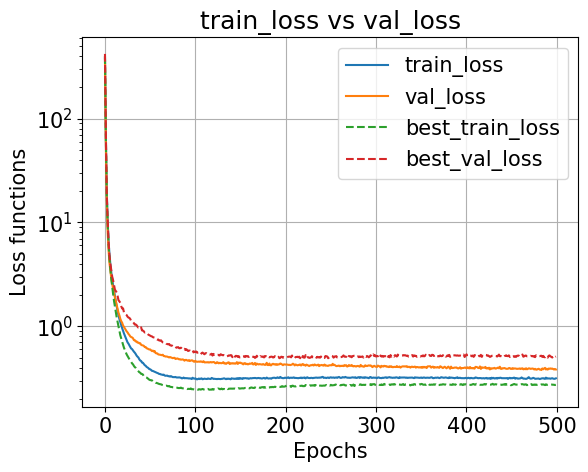

In [43]:
plt.plot(history['train_loss'],label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.plot(best_train_loss, '--', label='best_train_loss')
plt.plot(best_val_loss, '--', label='best_val_loss')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss functions', size=15)
plt.title('train_loss vs val_loss', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

In [38]:
best_params = train_params
best_train_loss = history['train_loss']
best_val_loss = history['val_loss']

In [36]:
best_params

{'hidden_dim': 70,
 'hidden_act_func': 'tanh',
 'hidden_dim2': 70,
 'hidden_act_func2': 'tanh',
 'hidden_dim3': 70,
 'hidden_act_func3': 'tanh',
 'eta': 0.0005,
 'lam': 3e-05,
 'alpha': 0.9,
 'n_batch': 50,
 'use_opt': 0,
 'l1_reg': False,
 'nest': True}

In [37]:
train_params = {
    'hidden_dim' : 25,
    'hidden_act_func' : 'relu',
    'hidden_dim2' : 25,
    'hidden_act_func2' : 'relu',
    'hidden_dim3' : 10,
    'hidden_act_func3' : 'relu',
    'eta' : 0.01,
    'lam' : 0.01,
    'alpha' : 0.5,
    'n_batch': 128,
    'use_opt': 0,
}
params = train_params.copy()
input_layer = Input(10)
hidden_layer = Layer(input_layer, params.pop('hidden_dim'), params.pop('hidden_act_func'))
hidden_layer = Layer(hidden_layer, params.pop('hidden_dim2'), params.pop('hidden_act_func2'))
hidden_layer = Layer(hidden_layer, params.pop('hidden_dim3'), params.pop('hidden_act_func3'))
output_layer = Layer(hidden_layer, 3, 'lin')

model = NeuralNetwork(input_layer, output_layer, loss = 'MSE', metrics=[MEE])
history = model.train(X_train_norm, y_train, epochs = 1000,
                                    ** params,
                                    validation_split = 0.2,
                                    early_stopping=None,
                                    reduce_eta=None
                                    )

Epoch 0: train_loss: 1.862e+17, val_loss: 1.862e+17; train_MEE: 3.342e+08, val_MEE: 3.342e+08  lr : 0.01
Epoch 1: train_loss: 6.206e+51, val_loss: 6.206e+51; train_MEE: 6.603e+25, val_MEE: 6.603e+25  lr : 0.01
Epoch 2: train_loss: 3.618e+49, val_loss: 3.618e+49; train_MEE: 1.041e+25, val_MEE: 1.041e+25  lr : 0.01
Epoch 3: train_loss: 2.549e+49, val_loss: 2.549e+49; train_MEE: 8.730e+24, val_MEE: 8.730e+24  lr : 0.01
Epoch 4: train_loss: 1.669e+49, val_loss: 1.669e+49; train_MEE: 7.063e+24, val_MEE: 7.063e+24  lr : 0.01
Epoch 5: train_loss: 1.089e+49, val_loss: 1.089e+49; train_MEE: 5.705e+24, val_MEE: 5.705e+24  lr : 0.01
Epoch 6: train_loss: 7.103e+48, val_loss: 7.103e+48; train_MEE: 4.608e+24, val_MEE: 4.608e+24  lr : 0.01
Epoch 7: train_loss: 4.633e+48, val_loss: 4.633e+48; train_MEE: 3.721e+24, val_MEE: 3.721e+24  lr : 0.01
Epoch 8: train_loss: 3.022e+48, val_loss: 3.022e+48; train_MEE: 3.006e+24, val_MEE: 3.006e+24  lr : 0.01
Epoch 9: train_loss: 1.971e+48, val_loss: 1.971e+48; tr

KeyboardInterrupt: 

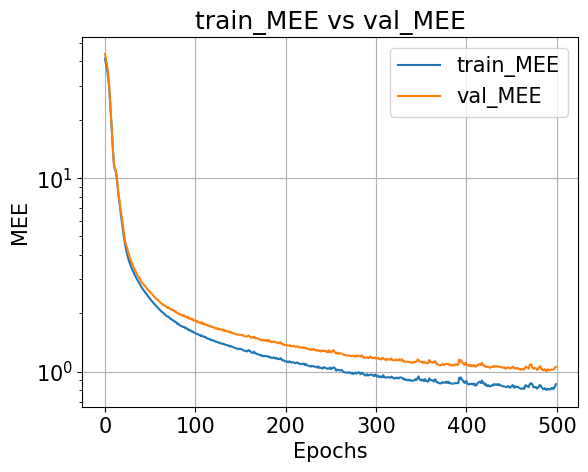

In [ ]:
plt.plot(history['train_MEE'],label='train_MEE')
plt.plot(history['val_MEE'], label='val_MEE')
plt.yscale('log')
plt.xlabel('Epochs', size=15)
plt.ylabel('MEE', size=15)
plt.title('train_MEE vs val_MEE', size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.legend(fontsize=15)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
def MRAE(y_pred, y_true):
    return (np.abs((y_pred - y_true)/y_true)/y_true.shape[1]).reshape(y_pred.shape)

In [ ]:
print(MRAE(y_pred, y_test).sum(axis=1))

[0.17134048 0.41987499 0.17962694]


In [ ]:
y_pred

array([[-4.82014940e+01, -1.21765954e+01,  6.72478599e+00,
         1.53731827e+01, -1.22375210e-02,  3.59401642e-01,
        -5.69870533e+01,  1.54983848e+01, -4.06117601e+00,
        -4.69271368e+01, -8.83137738e+00, -2.44062616e+01,
        -3.04445933e+01,  3.57653955e+00,  1.18805865e+01,
         3.83829002e+00, -6.25414144e-01, -6.17813255e+01,
        -1.37919555e+01,  4.52263920e+00, -3.90078463e+01,
         3.54567422e+00, -4.86872802e+01, -1.67295796e+01,
         1.20624276e+00, -4.53113428e+01,  2.22694352e+00,
         4.61185107e+00,  2.18810487e+00,  1.69879662e+00,
        -6.14052933e+01, -6.40553309e+01, -2.32152071e+01,
        -3.70747802e+01, -5.73955264e+01, -3.54470435e+01,
         6.47428002e-01,  4.73064307e+00, -5.11761979e+01,
        -1.84354714e+01,  7.17102522e+00, -3.40374054e+01,
         7.23920374e+00,  4.55919672e+00, -2.71977261e+01,
        -5.46631537e+01,  7.94195723e+00, -3.29880349e+01,
         7.73506715e+00, -4.66277772e+01,  1.04685745e+0

In [ ]:
y_test

array([[-4.91707340e+01, -1.18971060e+01,  6.97887000e+00,
         1.54351920e+01, -2.45094900e-01,  4.03467400e-01,
        -5.87634120e+01,  1.58288870e+01, -3.01825760e+00,
        -4.66138040e+01, -7.72302340e+00, -2.42441840e+01,
        -3.03221990e+01,  4.12125160e+00,  1.22751520e+01,
         3.30147430e+00, -1.85525400e+00, -6.31271400e+01,
        -1.31329120e+01,  4.80903670e+00, -3.78341100e+01,
         3.19164600e+00, -4.87959820e+01, -1.78932130e+01,
         1.38755380e+00, -4.49677350e+01,  1.90563860e+00,
         4.22560400e+00,  2.04188350e+00,  1.36303590e+00,
        -6.32393260e+01, -6.44570700e+01, -2.27842860e+01,
        -3.70299000e+01, -5.69650540e+01, -3.52268900e+01,
         1.49135900e+00,  3.84862610e+00, -5.15499530e+01,
        -1.95448250e+01,  7.06292870e+00, -3.51479640e+01,
         7.73133300e+00,  4.82422730e+00, -2.72254370e+01,
        -5.36919000e+01,  7.89745300e+00, -3.17605300e+01,
         7.71923830e+00, -4.70271200e+01,  1.04316050e+0

In [ ]:
a = np.array([[1,1,1],[1,1,1]])
print(a.sum())

6
